Título: Análise de Regressão Múltipla: Fatores Demográficos e Preparatórios no Desempenho Acadêmico.

Importação e preparação do dataset:

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import warnings

# Define o tema para os gráficos do seaborn
sns.set_theme(style="whitegrid")
# Ignora avisos de "deprecated" que podem aparecer
warnings.filterwarnings('ignore')


try:
    df = pd.read_csv("StudentsPerformance.csv")
    print("Dataset 'StudentsPerformance.csv' carregado com sucesso!")

    colunas_novas = {
        'gender': 'Genero',
        'race/ethnicity': 'RacaEtnia',
        'parental level of education': 'EducPais',
        'lunch': 'Almoco',
        'test preparation course': 'CursoPrep',
        'math score': 'NotaMat',
        'reading score': 'NotaLeit',
        'writing score': 'NotaEscr'
    }
    df.rename(columns=colunas_novas, inplace=True)

    print("\n--- Amostra dos dados com colunas renomeadas ---")
    print(df.head())
    print("\n" + "="*50 + "\n")

except FileNotFoundError:
    print("ERRO: Arquivo 'StudentsPerformance.csv' não encontrado.")
    print("Por favor, siga as instruções e faça o upload do arquivo para o Colab.")
    raise

Dataset 'StudentsPerformance.csv' carregado com sucesso!

--- Amostra dos dados com colunas renomeadas ---
   Genero RacaEtnia            EducPais        Almoco  CursoPrep  NotaMat  \
0  female   group B   bachelor's degree      standard       none       72   
1  female   group C        some college      standard  completed       69   
2  female   group B     master's degree      standard       none       90   
3    male   group A  associate's degree  free/reduced       none       47   
4    male   group C        some college      standard       none       76   

   NotaLeit  NotaEscr  
0        72        74  
1        90        88  
2        95        93  
3        57        44  
4        78        75  




In [63]:
vars_numericas = ['NotaMat', 'NotaLeit', 'NotaEscr']
vars_categoricas = ['Genero', 'RacaEtnia', 'EducPais', 'Almoco', 'CursoPrep']

Análise Exploratória:

Ponto 4a  e 4c: Assimetrias e Associações Numéricas
Usamos o pairplot (Matriz de Dispersão), que é excelente para isso. Ele mostra histogramas (diagonal) e gráficos de dispersão (resto).

Gerando Gráfico 1: Matriz de Dispersão (Pairplot)...


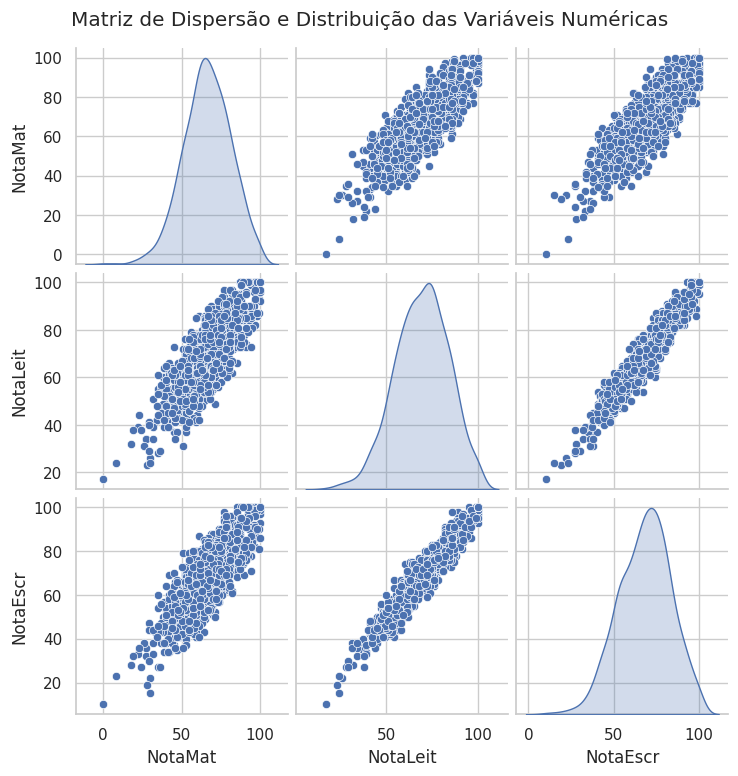

In [64]:
print("Gerando Gráfico 1: Matriz de Dispersão (Pairplot)...")

pair_plot = sns.pairplot(df, vars=vars_numericas, diag_kind='kde')
pair_plot.fig.suptitle('Matriz de Dispersão e Distribuição das Variáveis Numéricas', y=1.03)
plt.show()

Matriz de correlação (ponto 4c)

Gráfico 2: Matriz de Correlação (Heatmap)...


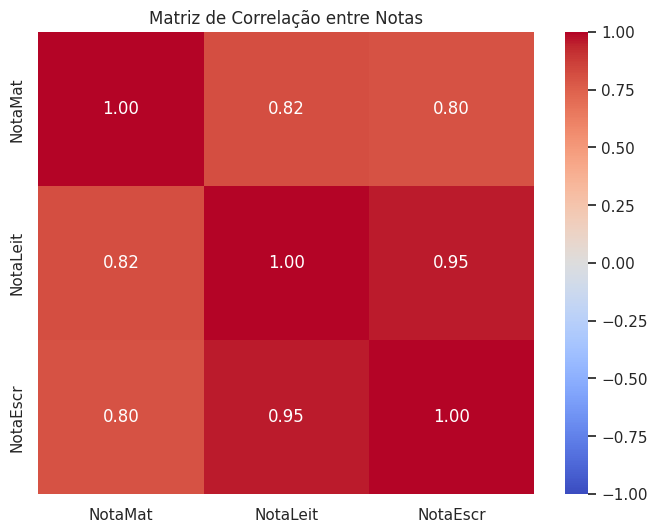


Valores da Matriz de Correlação:
           NotaMat  NotaLeit  NotaEscr
NotaMat   1.000000  0.817580  0.802642
NotaLeit  0.817580  1.000000  0.954598
NotaEscr  0.802642  0.954598  1.000000




In [65]:
print("Gráfico 2: Matriz de Correlação (Heatmap)...")
corr_matrix = df[vars_numericas].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

plt.title('Matriz de Correlação entre Notas')
plt.show()

print("\nValores da Matriz de Correlação:")
print(corr_matrix)
print("\n" + "="*50 + "\n")

Análise de Frequência das Variáveis Categóricas

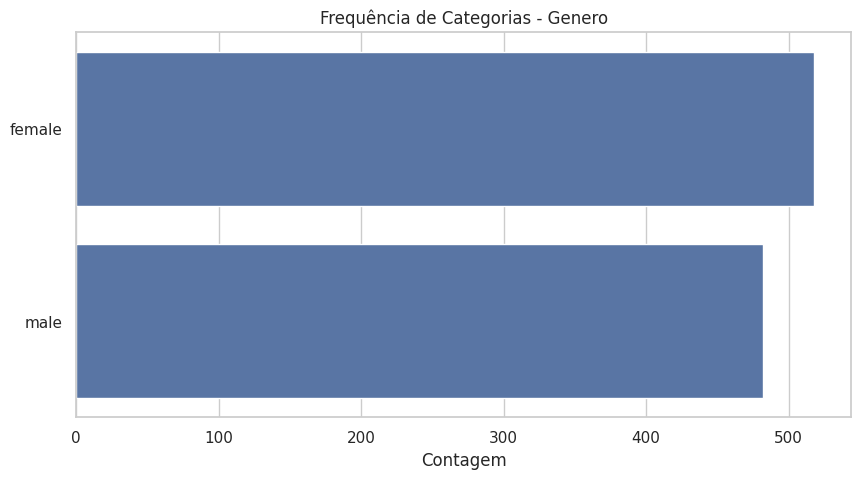

Contagem para 'Genero':
Genero
female    51.8%
male      48.2%
Name: proportion, dtype: object
------------------------------


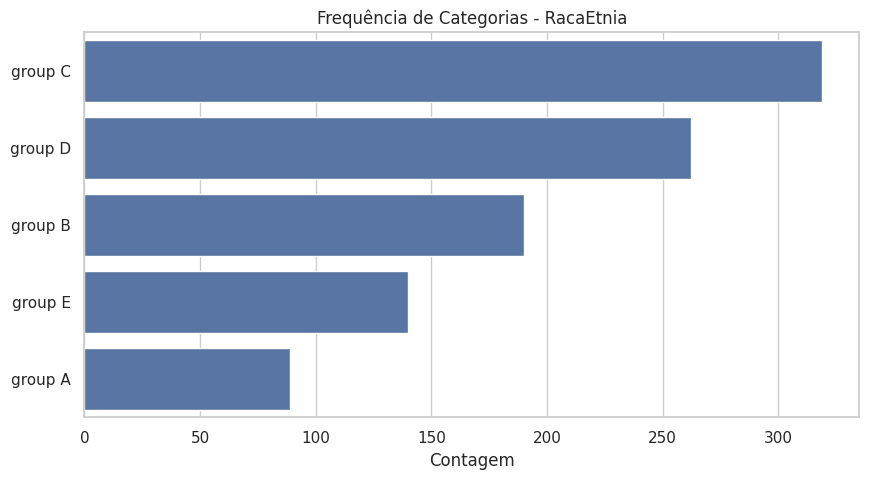

Contagem para 'RacaEtnia':
RacaEtnia
group C    31.9%
group D    26.2%
group B    19.0%
group E    14.0%
group A     8.9%
Name: proportion, dtype: object
------------------------------


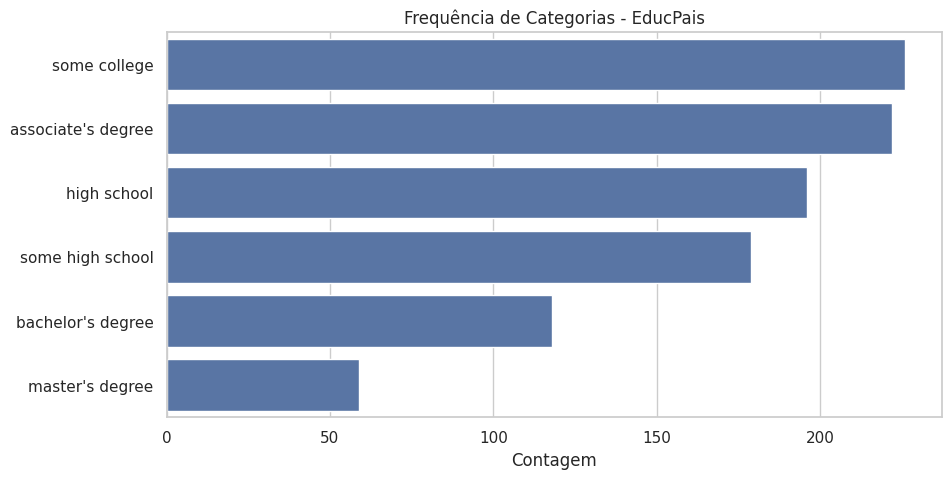

Contagem para 'EducPais':
EducPais
some college          22.6%
associate's degree    22.2%
high school           19.6%
some high school      17.9%
bachelor's degree     11.8%
master's degree        5.9%
Name: proportion, dtype: object
------------------------------


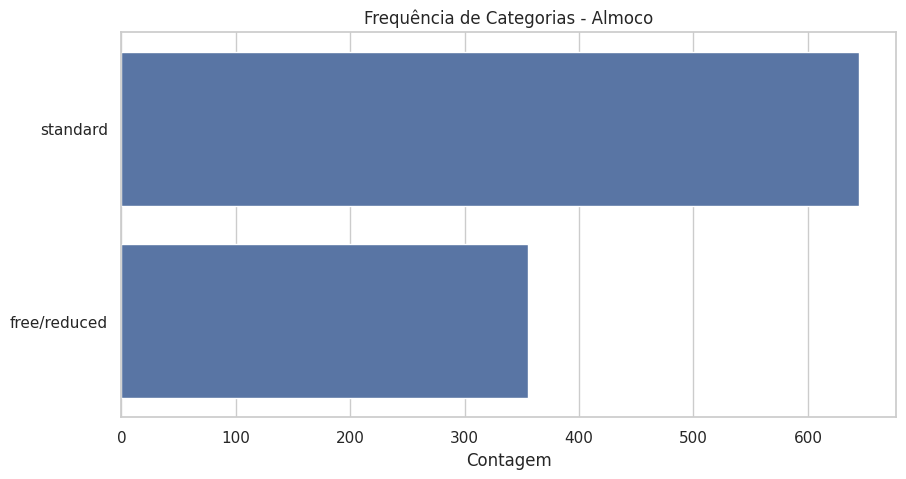

Contagem para 'Almoco':
Almoco
standard        64.5%
free/reduced    35.5%
Name: proportion, dtype: object
------------------------------


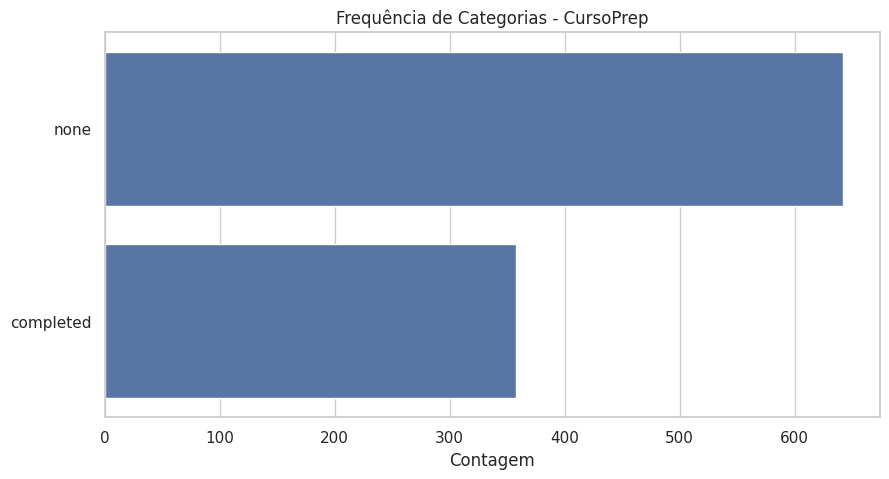

Contagem para 'CursoPrep':
CursoPrep
none         64.2%
completed    35.8%
Name: proportion, dtype: object
------------------------------




In [66]:
for var in vars_categoricas:
    plt.figure(figsize=(10, 5))
    # Usar 'y=var' (horizontal) é melhor para labels longos
    sns.countplot(y=df[var], order = df[var].value_counts().index)
    plt.title(f'Frequência de Categorias - {var}')
    plt.xlabel('Contagem')
    plt.ylabel('')
    plt.show()

    # Imprimir a contagem exata para facilitar a análise de "frequências muito baixas"
    print(f"Contagem para '{var}':")
    print(df[var].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print("-" * 30)

print("\n" + "="*50 + "\n")

Associação entre Resposta (Numérica) e Preditores (Categóricos)

Distribuição 1


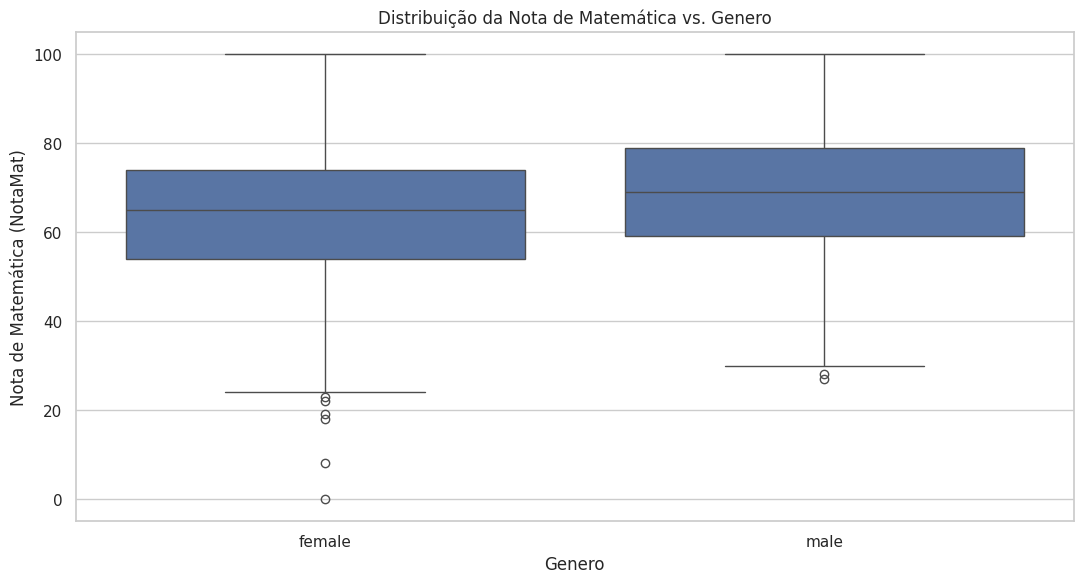



Distribuição 2


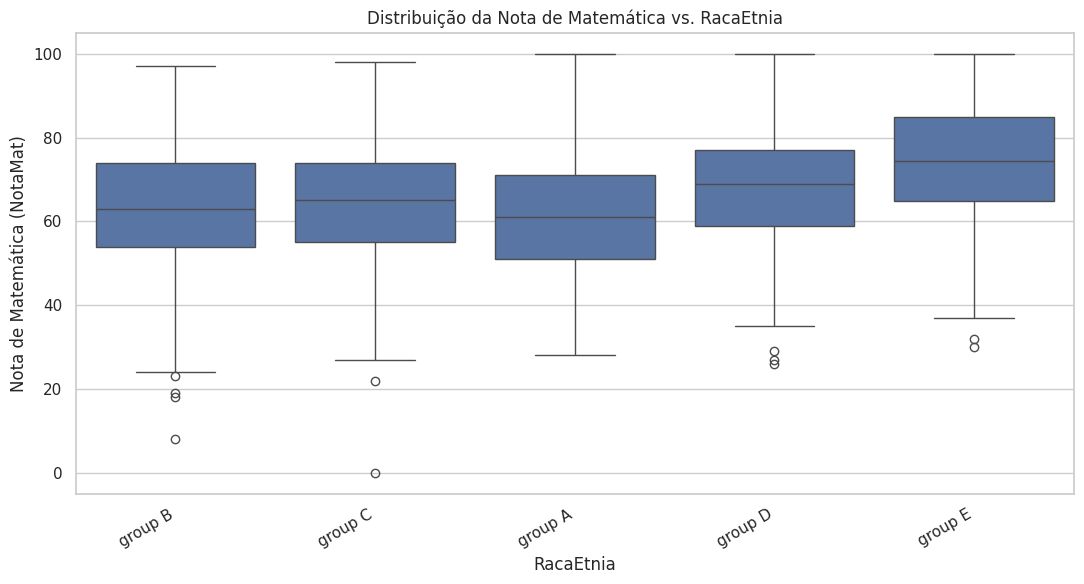



Distribuição 3


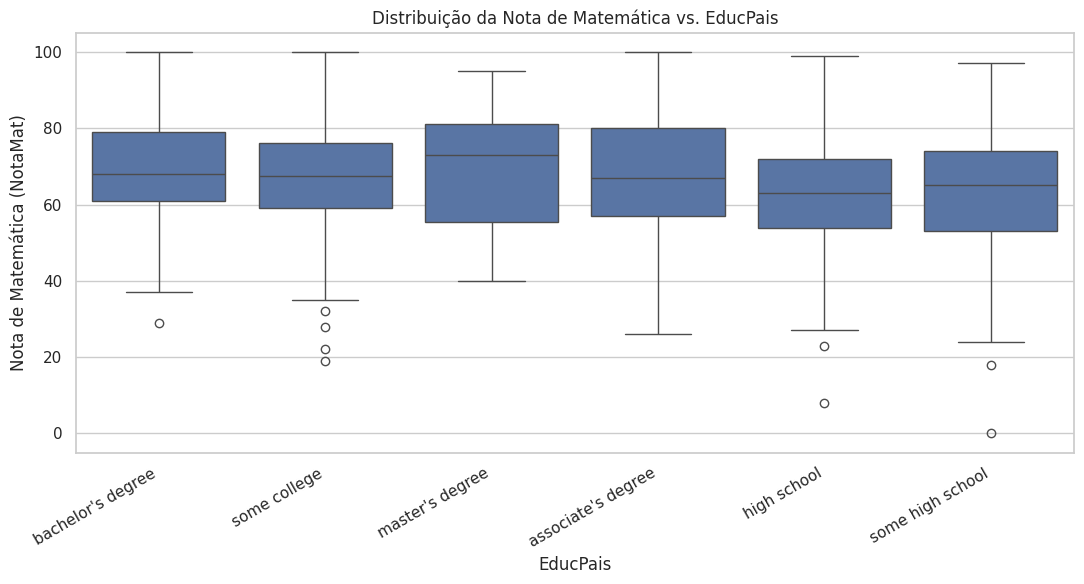



Distribuição 4


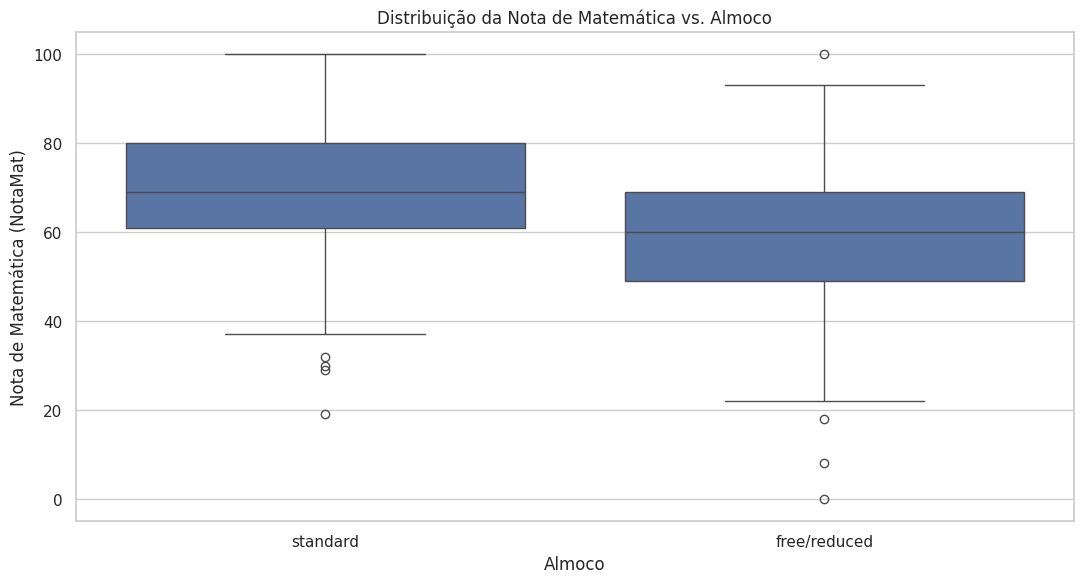



Distribuição 5


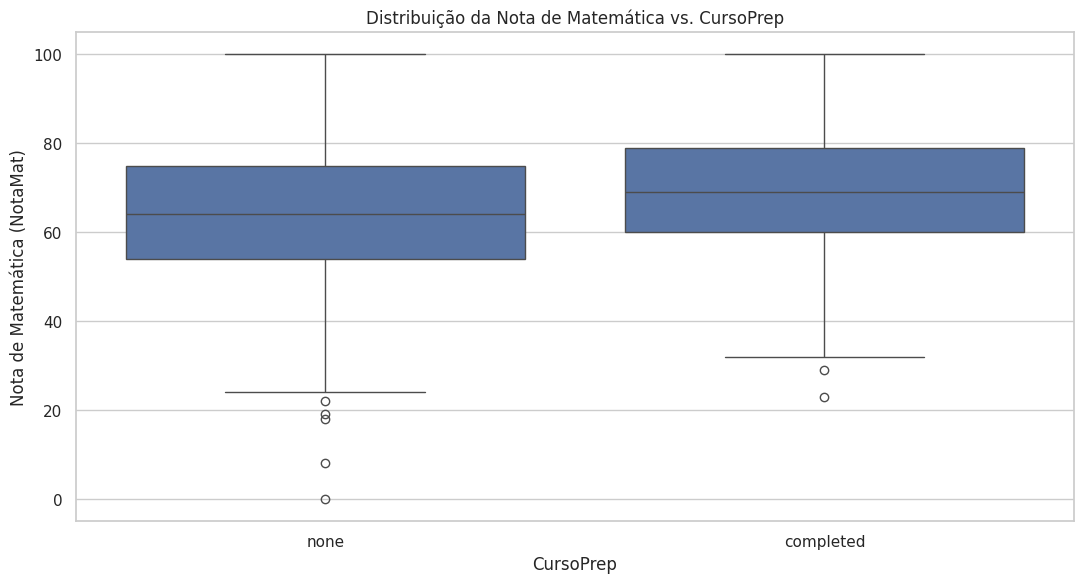

In [67]:
for index, var in enumerate(vars_categoricas):
    print(f"Distribuição {index+1}")
    plt.figure(figsize=(11, 6))
    sns.boxplot(x=df[var], y=df['NotaMat'])
    plt.title(f'Distribuição da Nota de Matemática vs. {var}')
    plt.ylabel('Nota de Matemática (NotaMat)')
    plt.xlabel(var)

    # Rotacionar labels se forem longos (como EducPais)
    if len(df[var].unique()) > 4:
        plt.xticks(rotation=30, ha='right')

    plt.tight_layout()
    plt.show()

    print("\n")

O statsmodels usa uma sintaxe de "fórmula" (similar ao R).
Queremos prever 'NotaMat' usando todas as outras variáveis.
O 'C()' é usado para dizer ao statsmodels que a variável é Categórica.

In [68]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


formula = 'NotaMat ~ NotaLeit + NotaEscr + C(Genero) + C(RacaEtnia) + C(EducPais) + C(Almoco) + C(CursoPrep)'

# Criamos e "treinamos" o modelo de Regressão Linear Múltipla (OLS - Ordinary Least Squares)
model = smf.ols(formula, data=df).fit()

# --- 3. Resultados e Discussões (Tópico e) ---

print("--- TÓPICO (e): RESULTADOS E DISCUSSÕES ---")

# Item 1: Tabela de Coeficientes
# Item 3: Valor do R² (original e ajustado)
#
# O .summary() do statsmodels gera uma tabela completa que inclui:
# - R-squared (R²) e Adj. R-squared (R² ajustado)
# - A tabela de coeficientes (coef), erros padrão (std err),
#   p-valor (P>|t|) e os intervalos de confiança ([0.025  0.975])
print("\n--- Tabela de Coeficientes, R² e R² Ajustado ---")
print(model.summary())
print("\n" + "="*50 + "\n")


# Item 2: Tabela da Análise de Variância (ANOVA)
print("\n--- Tabela da Análise de Variância (ANOVA) ---")
# Usamos typ=2 para a ANOVA (Type II SS), que é padrão para modelos com múltiplas variáveis
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("\n" + "="*50 + "\n")


print("\n--- Geração de resultados concluída ---")

--- TÓPICO (e): RESULTADOS E DISCUSSÕES ---

--- Tabela de Coeficientes, R² e R² Ajustado ---
                            OLS Regression Results                            
Dep. Variable:                NotaMat   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     500.3
Date:                Mon, 10 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:14:34   Log-Likelihood:                -3090.7
No. Observations:                1000   AIC:                             6211.
Df Residuals:                     985   BIC:                             6285.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

Gráficos de resíduos e Testes Estatísticos



--- TÓPICO (e): ANÁLISE DE RESÍDUOS ---

--- Gráfico 1: Histograma dos Resíduos (Análise de Normalidade) ---


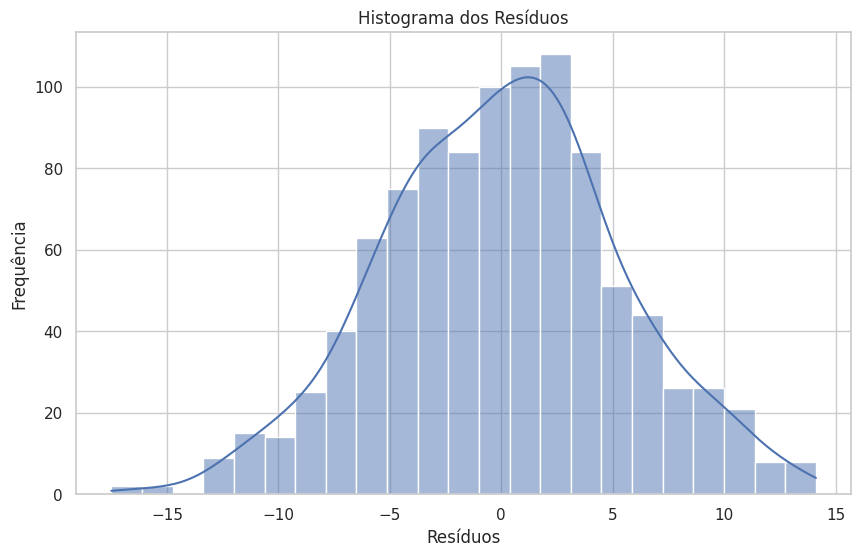


--- Gráfico 2: QQ-Plot dos Resíduos (Análise de Normalidade) ---


<Figure size 800x600 with 0 Axes>

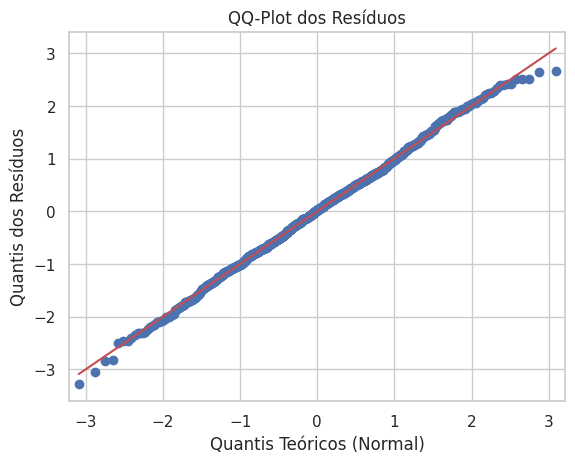


--- Gráfico 3: Resíduos vs. Valores Preditos (Análise de Homocedasticidade) ---


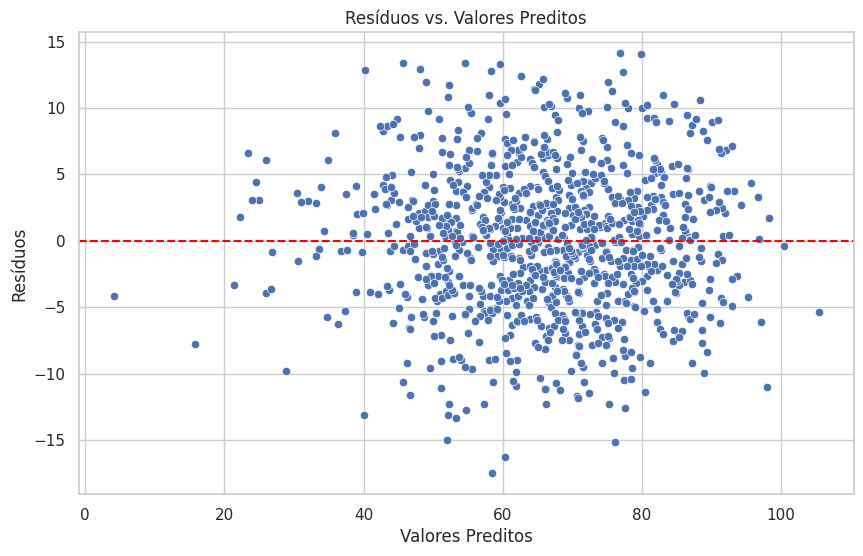



--- TÓPICO (e): TESTES ESTATÍSTICOS SOBRE RESÍDUOS ---

--- Teste de Normalidade (Shapiro-Wilk) ---
Estatística do Teste: 0.9983
P-valor: 0.4088
Interpretação: P-valor > 0.05. Não rejeitamos a hipótese nula (H0). Os resíduos parecem seguir uma distribuição normal.

--- Teste de Homocedasticidade (Breusch-Pagan) ---
P-valor (usando Estatística F): 0.2879
Interpretação: P-valor > 0.05. Não rejeitamos a hipótese nula (H0). Os resíduos são homocedásticos (variância constante).




In [69]:
# --- 4. Análise de Resíduos (Tópico e) ---
print("\n" + "="*50 + "\n")
print("--- TÓPICO (e): ANÁLISE DE RESÍDUOS ---")

# Extrair resíduos e valores preditos
residuos = model.resid
valores_preditos = model.fittedvalues

# --- Item 4a: Gráficos dos Resíduos ---

print("\n--- Gráfico 1: Histograma dos Resíduos (Análise de Normalidade) ---")
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

print("\n--- Gráfico 2: QQ-Plot dos Resíduos (Análise de Normalidade) ---")
plt.figure(figsize=(8, 6))
sm.qqplot(residuos, line='s', fit=True, dist=stats.norm)
plt.title('QQ-Plot dos Resíduos')
plt.xlabel('Quantis Teóricos (Normal)')
plt.ylabel('Quantis dos Resíduos')
plt.show()

print("\n--- Gráfico 3: Resíduos vs. Valores Preditos (Análise de Homocedasticidade) ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=valores_preditos, y=residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Resíduos vs. Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()


# --- Item 4b: Testes Estatísticos sobre os Resíduos ---

print("\n" + "="*50 + "\n")
print("--- TÓPICO (e): TESTES ESTATÍSTICOS SOBRE RESÍDUOS ---")

# 1. Teste de Normalidade (Shapiro-Wilk)
# H0: Os dados seguem uma distribuição normal.
# Se p-valor > 0.05, não rejeitamos H0 (os dados são normais).
shapiro_stat, shapiro_p = stats.shapiro(residuos)
print(f"\n--- Teste de Normalidade (Shapiro-Wilk) ---")
print(f"Estatística do Teste: {shapiro_stat:.4f}")
print(f"P-valor: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Interpretação: P-valor > 0.05. Não rejeitamos a hipótese nula (H0). Os resíduos parecem seguir uma distribuição normal.")
else:
    print("Interpretação: P-valor <= 0.05. Rejeitamos a hipótese nula (H0). Os resíduos NÃO parecem seguir uma distribuição normal.")

# 2. Teste de Homogeneidade de Variâncias (Breusch-Pagan)
# H0: A variância dos resíduos é constante (homocedasticidade).
# Se p-valor > 0.05, não rejeitamos H0 (as variâncias são constantes).
bp_test = sm.stats.het_breuschpagan(residuos, model.model.exog)
labels = ['Estatística LM', 'P-valor (LM)', 'Estatística F', 'P-valor (F)']
print(f"\n--- Teste de Homocedasticidade (Breusch-Pagan) ---")
print(f"P-valor (usando Estatística F): {bp_test[3]:.4f}")

if bp_test[3] > 0.05:
    print("Interpretação: P-valor > 0.05. Não rejeitamos a hipótese nula (H0). Os resíduos são homocedásticos (variância constante).")
else:
    print("Interpretação: P-valor <= 0.05. Rejeitamos a hipótese nula (H0). Os resíduos são heterocedásticos (variância não é constante).")

print("\n" + "="*50 + "\n")